<a href="https://colab.research.google.com/github/Bint7bara/KerasEvaluateModule/blob/master/ensemble_keras_binary_classifier_12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

!pip install  tensorflow_decision_forests==0.2.5
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_decision_forests as tfdf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import tensorflow as tf
print(tf.__version__)

2.9.2


In [3]:
seed = 7

# load pima indians dataset
dataset = np.loadtxt("NewGencode4DLTraining2.csv", delimiter=",")
# split into input (X) and output (Y) variables
X = dataset[:,0:12]
Y = dataset[:,12]

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, Y, 
    test_size=0.2, random_state=42
)
X_train,y_train

(array([[ 2.69465671e-05,  1.36104279e-06,  8.57400000e-01, ...,
          5.40386800e-02, -5.42105263e-01,  1.31400000e+03],
        [ 2.02332789e-04,  1.18597914e-07,  1.28090000e+00, ...,
          1.02175970e-01, -3.40088106e-01,  6.84000000e+02],
        [ 5.49928044e-06,  3.14581615e-05,  5.23900000e-01, ...,
          4.72553700e-02, -2.36842105e-01,  2.31000000e+02],
        ...,
        [ 3.39736457e-07,  4.06913407e-07,  1.23220000e+00, ...,
          7.06860710e-02, -3.11538462e-01,  3.15000000e+02],
        [ 2.04195878e-05,  6.72560437e-05,  9.38900000e-01, ...,
          1.00467290e-01, -1.06481482e+00,  1.65000000e+02],
        [ 4.55885483e-06,  3.10816341e-06,  1.10460000e+00, ...,
          1.12017804e-01,  1.83272727e-01,  8.28000000e+02]]),
 array([1., 1., 0., ..., 0., 1., 1.]))

In [5]:
# Input features.
num_features = 12
raw_features = tf.keras.layers.Input(shape=(num_features,))

# Stage 1
# =======

# Common learnable pre-processing
preprocessor = tf.keras.layers.Dense(12, activation=tf.nn.relu6)
preprocess_features = preprocessor(raw_features)

# Stage 2
# =======

# Model #1: NN
m1_z1 = tf.keras.layers.Dense(5, activation=tf.nn.relu6)(preprocess_features)
m1_pred = tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)(m1_z1)

# Model #2: NN
m2_z1 = tf.keras.layers.Dense(5, activation=tf.nn.relu6)(preprocess_features)
m2_pred = tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)(m2_z1)


# Model #3: DF
model_3 = tfdf.keras.RandomForestModel(num_trees=1000, random_seed=1234)
m3_pred = model_3(preprocess_features)

# Model #4: DF
model_4 = tfdf.keras.RandomForestModel(
    num_trees=1000,
    #split_axis="SPARSE_OBLIQUE", # Uncomment this line to increase the quality of this model
    random_seed=4567)
m4_pred = model_4(preprocess_features)

# Since TF-DF uses deterministic learning algorithms, you should set the model's
# training seed to different values otherwise both
# `tfdf.keras.RandomForestModel` will be exactly the same.

# Stage 3
# =======

mean_nn_only = tf.reduce_mean(tf.stack([m1_pred, m2_pred], axis=0), axis=0)
mean_nn_and_df = tf.reduce_mean(
    tf.stack([m1_pred, m2_pred, m3_pred, m4_pred], axis=0), axis=0)

# Keras Models
# ============

ensemble_nn_only = tf.keras.models.Model(raw_features, mean_nn_only)
ensemble_nn_and_df = tf.keras.models.Model(raw_features, mean_nn_and_df)

Use /tmp/tmpr8llstnk as temporary training directory


Use /tmp/tmpdue7gixp as temporary training directory


In [6]:
def make_tf_dataset(features, labels, batch_size=128, **args):
  # features, labels = make_dataset(**args)
  return tf.data.Dataset.from_tensor_slices(
      (features, labels)).batch(batch_size)


num_features = 12

train_dataset = make_tf_dataset(X_train, y_train)
    # num_examples=2500, num_features=num_features, batch_size=100, seed=1234)
test_dataset = make_tf_dataset(X_test, y_test)
    # num_examples=10000, num_features=num_features, batch_size=100, seed=5678)

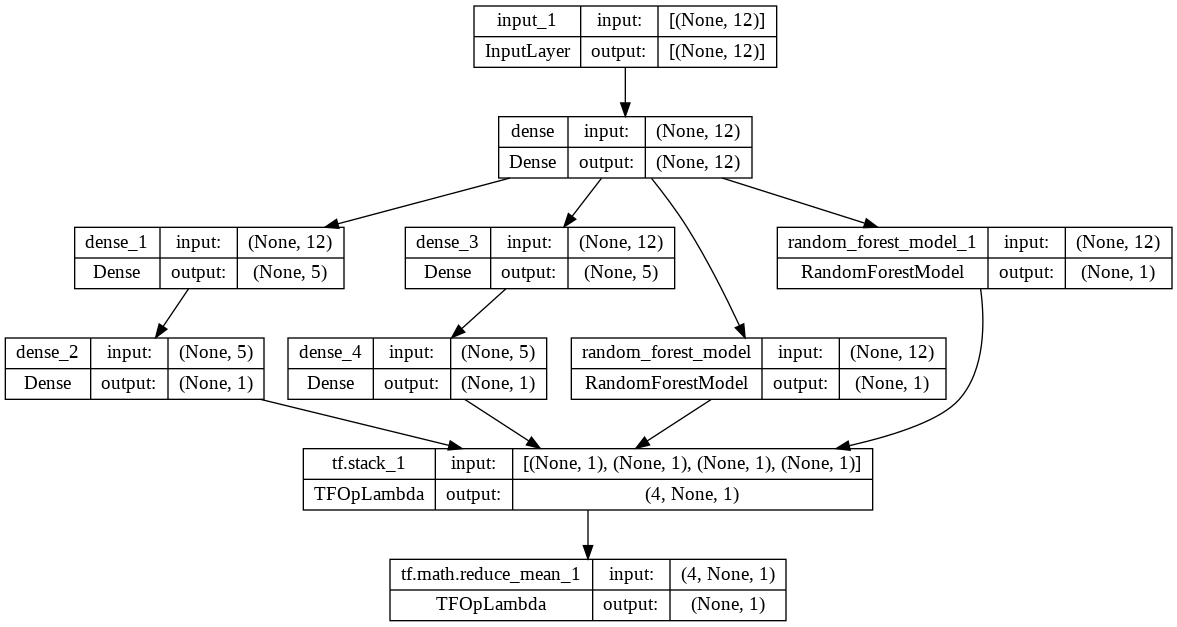

In [10]:
from keras.utils.vis_utils import plot_model

plot_model(ensemble_nn_and_df, to_file="/tmp/model.png", show_shapes=True)

In [30]:
%%time
ensemble_nn_only.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=["accuracy"])

ensemble_nn_only.fit(
    train_dataset,
    batch_size=128,
    epochs=120,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(test_dataset),
)

Epoch 1/120
173/173 [==============================] - 2s 4ms/step - loss: 0.2522 - accuracy: 0.9011 - val_loss: 0.2544 - val_accuracy: 0.9026
Epoch 2/120
173/173 [==============================] - 2s 10ms/step - loss: 0.2520 - accuracy: 0.9008 - val_loss: 0.2541 - val_accuracy: 0.9032
Epoch 3/120
173/173 [==============================] - 2s 9ms/step - loss: 0.2522 - accuracy: 0.9009 - val_loss: 0.2545 - val_accuracy: 0.9019
Epoch 4/120
173/173 [==============================] - 1s 3ms/step - loss: 0.2514 - accuracy: 0.9010 - val_loss: 0.2541 - val_accuracy: 0.9024
Epoch 5/120
173/173 [==============================] - 2s 11ms/step - loss: 0.2510 - accuracy: 0.9010 - val_loss: 0.2539 - val_accuracy: 0.9028
Epoch 6/120
173/173 [==============================] - 1s 8ms/step - loss: 0.2506 - accuracy: 0.9015 - val_loss: 0.2525 - val_accuracy: 0.9026
Epoch 7/120
173/173 [==============================] - 1s 3ms/step - loss: 0.2504 - accuracy: 0.9015 - val_loss: 0.2522 - val_accuracy: 0.90

In [12]:
evaluation_nn_only = ensemble_nn_only.evaluate(test_dataset, return_dict=True, batch_size=128)
print("test loss, test acc:", evaluation_nn_only)

44/44 [==============================] - 0s 2ms/step - loss: 0.2565 - accuracy: 0.8992
test loss, test acc: {'loss': 0.2564648389816284, 'accuracy': 0.8991840481758118}


In [13]:
model_3.compile(["accuracy"])
model_4.compile(["accuracy"])


In [14]:
%time
#train_dataset_with_preprocessing = train_dataset.map(lambda x,y: (preprocessor(x), y))
#test_dataset_with_preprocessing = test_dataset.map(lambda x,y: (preprocessor(x), y))
#%time
train_dataset_with_preprocessing = train_dataset.map(lambda x,y: (preprocessor(x), y))
test_dataset_with_preprocessing = test_dataset.map(lambda x,y: (preprocessor(x), y))


CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.06 µs


In [15]:
model_3.fit(train_dataset_with_preprocessing)
model_4.fit(train_dataset_with_preprocessing)
#model_3.fit(X_train,y_train)
#model_4.fit(X_train,y_train)
#model_3.fit(preprocessor(X_train),y_train)
#model_4.fit(preprocessor(X_train),y_train)


Reading training dataset...
Training dataset read in 0:00:06.805682. Found 22056 examples.
Training model...
Model trained in 0:01:00.104908
Compiling model...


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model compiled.
Reading training dataset...
Training dataset read in 0:00:00.414786. Found 22056 examples.
Training model...
Model trained in 0:01:01.456192
Compiling model...
Model compiled.


In [16]:

#evaluation_df3_only = model_3.evaluate(
 #   X_test, y_test, return_dict=True)
#evaluation_df4_only = model_4.evaluate(
 #   X_test,y_test, return_dict=True)


In [17]:
evaluation_df3_only = model_3.evaluate(
    test_dataset_with_preprocessing, return_dict=True)
evaluation_df4_only = model_4.evaluate(
    test_dataset_with_preprocessing, return_dict=True)

44/44 [==============================] - 2s 50ms/step - loss: 0.0000e+00 - accuracy: 0.9030


In [18]:
print("Accuracy (DF #3 only): ", evaluation_df3_only["accuracy"])
print("Accuracy (DF #4 only): ", evaluation_df4_only["accuracy"])

Accuracy (DF #3 only):  0.9033544659614563
Accuracy (DF #4 only):  0.9029918313026428


In [19]:
ensemble_nn_and_df.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), metrics=["accuracy"])


evaluation_nn_and_df = ensemble_nn_and_df.evaluate(test_dataset,return_dict=True)



44/44 [==============================] - 6s 112ms/step - loss: 0.2615 - accuracy: 0.9023


In [20]:
print("Accuracy (2xNN and 2xDF): ", evaluation_nn_and_df["accuracy"])
print("Loss (2xNN and 2xDF): ", evaluation_nn_and_df["loss"])

Accuracy (2xNN and 2xDF):  0.9022665619850159
Loss (2xNN and 2xDF):  0.26147568225860596


In [21]:
mean_df_only = tf.reduce_mean(tf.stack([m3_pred, m4_pred], axis=0), axis=0)
# mean_nn_and_df = tf.reduce_mean(
#    tf.stack([m1_pred, m2_pred, m3_pred, m4_pred], axis=0), axis=0)

# Keras Models
# ============

ensemble_df_only = tf.keras.models.Model(raw_features, mean_df_only)
#ensemble_nn_and_df = tf.keras.models.Model(raw_features, mean_nn_and_df)

In [22]:
%%time
ensemble_df_only.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=["accuracy"])


CPU times: user 9.41 ms, sys: 909 µs, total: 10.3 ms
Wall time: 12.9 ms


In [23]:
# ensemble_df_only.fit(
  #  X_train,
   # y_train,
    # batch_size=64,
    # epochs=100,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    # validation_data=(X_test, y_test),
#)

In [24]:
#ensemble_nn_and_df.compile(
#    loss=tf.keras.losses.BinaryCrossentropy(), metrics=["accuracy"])


evaluation_df_only = ensemble_df_only.evaluate(test_dataset, return_dict=True)

print("Accuracy (2xNN and 2xDF): ", evaluation_df_only["accuracy"])
print("Loss (2xNN and 2xDF): ", evaluation_df_only["loss"])

44/44 [==============================] - 4s 78ms/step - loss: 0.5052 - accuracy: 0.9034
Accuracy (2xNN and 2xDF):  0.9033544659614563
Loss (2xNN and 2xDF):  0.5052348375320435


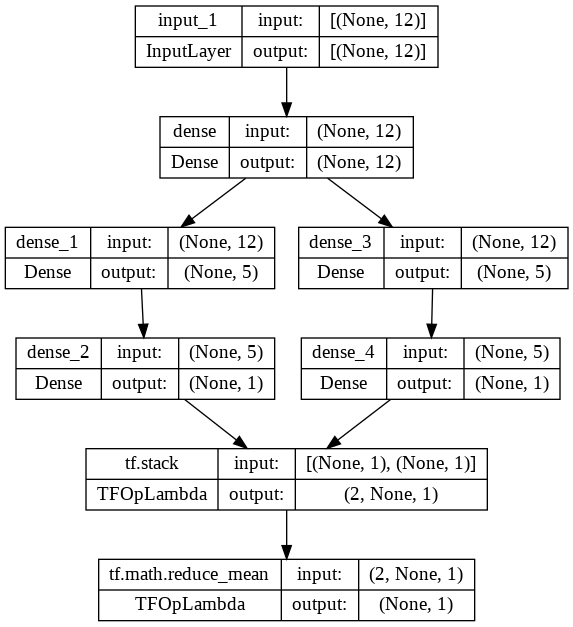

In [25]:
from keras.utils.vis_utils import plot_model

plot_model(ensemble_nn_only, to_file="/tmp/model-nn-only.png", show_shapes=True)

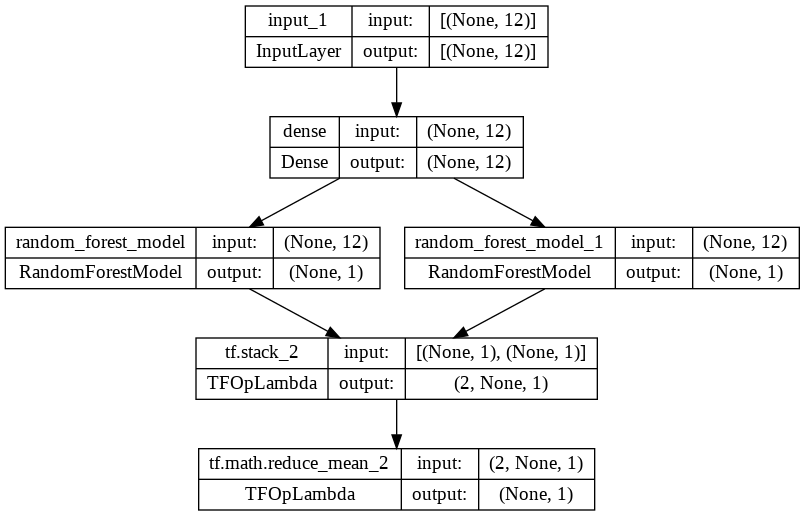

In [26]:
from keras.utils.vis_utils import plot_model

plot_model(ensemble_df_only, to_file="/tmp/model-df-only.png", show_shapes=True)

In [27]:
def make_dataset(num_examples, num_features, seed=1234):
  np.random.seed(seed)
  features = np.random.uniform(-1, 1, size=(num_examples, num_features))
  noise = np.random.uniform(size=(num_examples))

  left_side = np.sqrt(
      np.sum(np.multiply(np.square(features[:, 0:2]), [1, 2]), axis=1))
  right_side = features[:, 2] * 0.7 + np.sin(
      features[:, 3] * 10) * 0.5 + noise * 0.0 + 0.5

  labels = left_side <= right_side
  return features, labels.astype(int)

In [28]:
example_dataset = make_dataset(num_examples=5, num_features=4)

In [29]:
# train_dataset = (X_train, y_train)
# test_dataset = (X_test, y_test)